## Establishing the baseline for beach litter on Lake Geneva

#### Purpose

1. Determine the probability of finding a range of trash, measured in pieces/meter (pcs/m), on the shoreline of Lake Geneva
2. Identify the minimum number of annual samples required to get a representative population for the lake
3. Demonstrate the importance of having observations from a variety of groups and locations
4. Demonstrate a simple method to measure effectveness of litter mitigation stratgies on a regional scale

#### Usage:

1. These figures and scripts are intended to be used for publication and communication
2. Ask before you use
3. Give credit to _hammerdirt_, _EPFL Solid Waste Engineering_, _Swiss Litter Report_, _Geneva International school_, _Precious Plastic Léman_, _WWF.ch volunteers_

#### Tips:

1. The data is coming from the API; you can do your own analysis
2. Type "help(endOfYearThree)" in an empty cell to see the functions written for this workbook
3. Type inspect.getsource(function) to see the function source code
4. This is a functioning workbook the repo is here https://github.com/hammerdirt/solidWaste2018
5. Check the requirements.yml file in the repo if this workbook doesn't run right

#### Contact:

1. roger@hammerdirt.ch
2. twitter: @hammerdirt, Github: @hammerdirt
3. https://mwshovel.pythonanywhere.com/

### Abstract

The value of beach-litter surveys as a method for determining trash loads on beaches in the marine environment has recieved alot of attention. Recently there has been a push to use the data gathered by volunteers to determine trends overtime of the amplititude of beach-litter, specifically seasonal trends.

Here we propose another method based on the same data, following the Marine Litter Watch and OSPAR protocols on one of Europes largest natural lakes. By using the year over year distribution of survey results we are able to determine trends overtime despite heterogenous sampling schedules, different participants and a variety of locations.

In [1]:
# there are many more imports in the endOfYearThree.py file
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import numpy as np
import json
import inspect
from IPython.display import display
from scipy.stats import lognorm
import statsmodels.api as sm
# specific local imports
import endOfYearThree
from endOfYearThree import *

### Introduction:

#### Litter surveillance on the Lake:

Freshwater systems are considered to be principal routes of transmission of anthropogenic litter (AL) to the oceans. However in relation to the ocean, accumulation and transport of AL is rarely studied in freshwater systems. Current studies are not comparable because protocols for freshwater systems have yet to be standardized. Although public education and outreach are key components of the swiss litter prevention program, there is no publicly or privately funded systematic surveillance of AL on swiss waterways.

The project on Lake Geneva was designed to fill that Knowledge gap by providing data using an established protocol that was recognized by European member states: Marine Litter Watch (MLW) or OSPAR. Both systems are designed to be implemented at the local level, require minimal financial resources and put the “citizen” at the center of data collection.

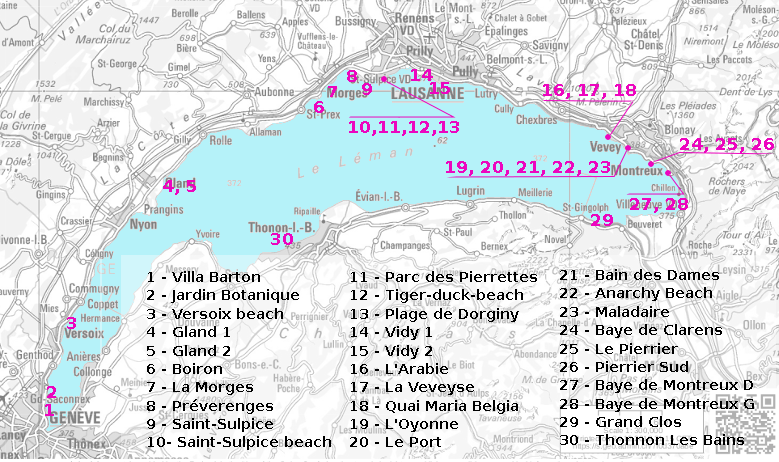

__What does this represent?__

__Numerically__ this represents 51'119 objects found on the lakeshore classified/identified in 148 surveys from 30 locations. Put in a context of environmental awareness __this represents the collected observations of five different groups:__

1. Volunteers from a national and global environmental NGO
2. Elementary school children
3. Graduate students from a leading technical univiversity
4. Members of a local NGO involved in transforming discarded plastic
5. Volunteer lifeguards and environmental militants

__How should this be interpreted?__

This should be interpreted as an index of how much and what type of trash a person is likeley to come into contact with when they visit the lakeshore. The index is sensitive both in quantative and categorical terms. We can just as easily sort data by type of object (material, description) or quantity.

The year over year distributions should be seen as a measure of effectiveness. As more or less resources are allocated to the problem there should be a corresponding movement in the probability distribution. If more resources are allocated year over year but there is no movement in the distribution then authorities should be questioning effectiveness of the current and past strategies.

Using this index authorities can allocate resources based on __litter reduction for every CHF allocated.__

## Data collection and access

### The program:

Surveillance of AL on Lake Geneva is based on the principle that shoreline litter is a proxy for AL in the water system. This implies that participants restrict debris collection to a fixed length of shoreline and maintain a search perimeter within the strand-line. Although the level of Lake Geneva is maintained at a relatively constant rate, the location of the strand-line varies throughout the year. Participants must use their judgment when determining the “width” of the collection area.

The method:

Sampling: participants select a length of beach and identify the strand-line:
1. The limits of the sampling area are identified and marked
2. All anthropogenic debris is collected and deposited on a flat surface.
3. Objects are sorted and counted according to one of the MLW categories
4. Results are recorded either on paper or directly into the application with a connected device 

Data collected:
1. Beach location: latitude, longitude (the start point of the sample area)
2. Beach name: As defined by user
3. Sample length: meters to nearest integer value
4. Sample results per identified object

### Retrieve data from the API

The API is open, no password is needed to download data. Data can be retrieved easily by body of water or location by formatting the the search URL. There are three levels of aggregation:

1. Not aggregated: daily totals per date and location of an indentified objects
2. Daily total: the survey total all objects included
3. Summary: descriptive statistics for the body of water or location specified

The following URLS are used for this document:

1. Not aggregated: "http://mwshovel.pythonanywhere.com/dirt/codes/Lac-Léman/?format=json"
2. Daily totals: "http://mwshovel.pythonanywhere.com/dirt/daily-total/Lac-Léman/?format=json"
3. Summary statistics: http://mwshovel.pythonanywhere.com/dirt/summary/Lac-Léman/
4. Beach information: "http://mwshovel.pythonanywhere.com/dirt/beaches/Lac-Léman/?format=json"


For further information https://mwshovel.pythonanywhere.com/dirt/api_home.html

In [2]:
# urls
urlLakeDailyTotals = "http://mwshovel.pythonanywhere.com/dirt/daily-total/Lac-Léman/?format=json"
urlLakeCodeData = "http://mwshovel.pythonanywhere.com/dirt/codes/Lac-Léman/?format=json"
urlBeachInfo = "http://mwshovel.pythonanywhere.com/dirt/beaches/Lac-Léman/?format=json"

# getData() converts the from json to a data frame
lakeDailyTotals = getData(urlLakeDailyTotals)
lakeCodeTotals = getData(urlLakeCodeData)
lakeBeaches = getData(urlBeachInfo)

# add a pcs/m column
lakeDailyPcsM = pcs_m(lakeDailyTotals)
lakeCodePcsM = pcs_m(lakeCodeTotals)

# get the log of the pcs/m column
lakeDailyPcsM = logOfPcsMeter(lakeDailyPcsM )

### Check data for proper aggregation

For the puposes of this summary, the observations are being aggregated into the following groups:

1. MCBP - "Montreux Clean Beach Project": hammerdirt staff
   1. https://mwshovel.pythonanywhere.com/
2. SLR - "Swiss Litter Report": STOPPP and WWF volunteers
   1. http://www.stoppp.org/
3. SWE - "Solid Waste Engineering": Ecole Polytechnique Federal de Lausanne
   1. http://edu.epfl.ch/coursebook/en/solid-waste-engineering-ENV-500
4. PC - "Precious Collect": Precious Plastic Léman
   1. https://preciousplasticleman.ch/
5. GIS - "École International de Genéve": Students from the third grade class
   1. https://www.ecolint.ch/

#### There are three changes\*

1. The "SWE" beaches are either included in "tiger-duck" or "MCBP"
2. "mcbp" should be "MCBP"
3. Versoix beach should be attributed to GIS



*These changes do not affect the data stored online, to see how this is done check the function: changeProject()

In [3]:
sweBeaches = [(['Parc-des-Pierrettes','Plage-de-St-Sulpice', "Tiger-duck-beach", "Saint-Sulpice"], "SWE"), (["Versoix"], "GIS")]
changeProjects = ["mcbp"]
changeProject(sweBeaches, changeProjects, lakeBeaches)
# that should be good, now SWE and GIS will show up as projects
projectBeaches, projectList = getProjectBeaches(lakeBeaches) 

## Year over year results

The samples vary both in frequency and location. This is not by design it is a __by-product of any project that is unfunded and entireley reliant on volunteer resources__. 

As a result not all locations were sampled throughout the the three year period and the number of samples per location ranges from 1 to 18. The data set that results is a collection of geographical clusters that are themselves composed of a series of samples that vary both in location (within a subregion) and frequency.

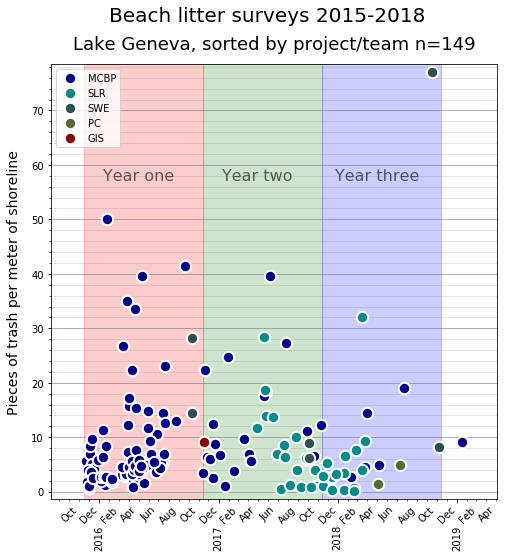

In [4]:
# Organize the data and assign values to the projects:
beachProjectDict = {vX:k for k,v in projectBeaches.items() for vX in v}

# Map those values to the data set
lakeDailyPcsM["Project"] = lakeDailyPcsM["location"].map(beachProjectDict)

# Change the dates from string to datetime stamp:
lakeDailyPcsM["date"] = pd.to_datetime(lakeDailyPcsM["date"])

# Draw the chart:
makeTimeSeriesAll((8,8),lakeDailyPcsM, projectList, "graphs/distributions/threeYearScatter.svg") 

## Participation and attribtution of "work"*

Through November 2018 there were five organisations that participated in the beach litter surveillance prorgram on the lake, all are volunteers or were "volunteered" (students). Understanding the results means understanding who collected the data.

The term "project" refers to a group or entity that participated in the surveillance.

#### *This applies only to data in the system, if a collection was done but the data never submitted it will not be included in this survey.

### Number of surveys per project:

In [5]:
operationsPerProject = surveysPerProject(projectList, projectBeaches, lakeDailyPcsM)
display(operationsPerProject)

MCBP    107
SLR      33
SWE       6
PC        2
GIS       1
dtype: int64

### Number of unique locations surveyed per project:

In [6]:
projectBeachCount = lakeBeaches.location.groupby(lakeBeaches.project_id).count()
display(projectBeachCount)

project_id
GIS      1
MCBP    22
PC       1
SLR      4
SWE      4
Name: location, dtype: int64

### Year over year locations and number of samples:

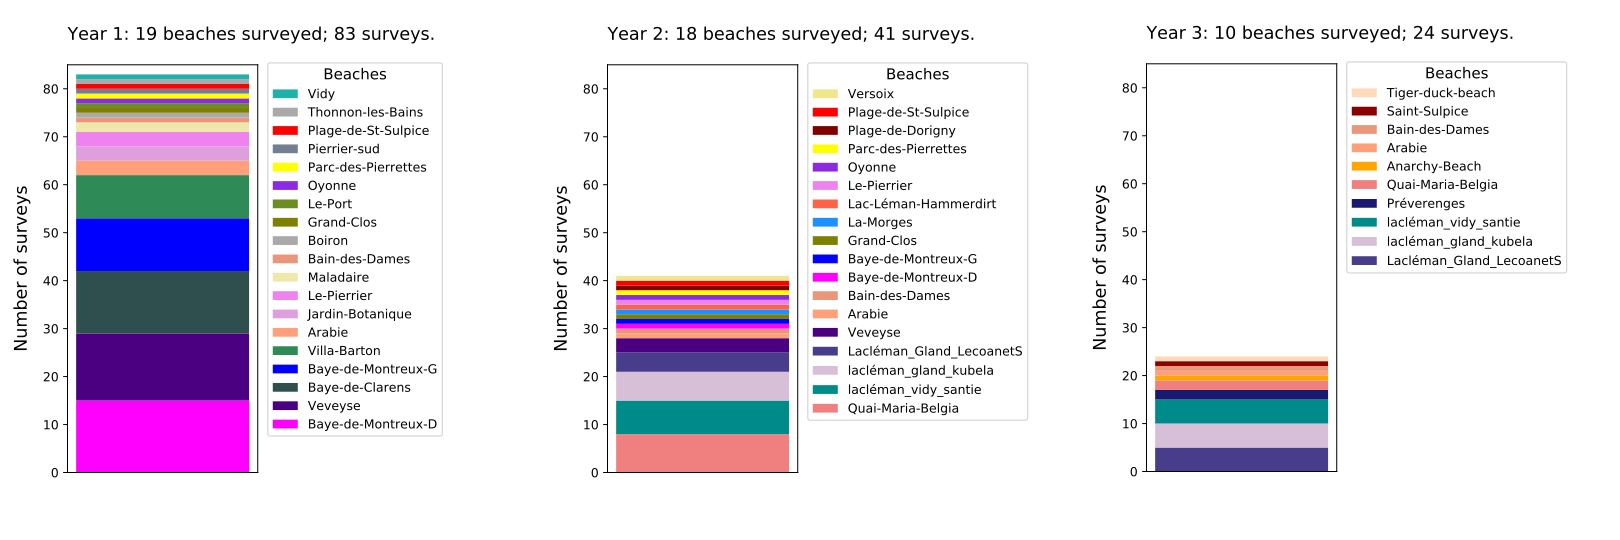

In [7]:
# making the barcharts

# Get the data by year and grab the location column
locations = makeYearResults(["2016-11-15", "2017-11-15", "2018-11-15"],lakeDailyPcsM, "location")

# Get the unique beach names in:
beachListAll = list(lakeDailyPcsM.location.unique())

# Pull some random colors from the matplotlib library:
colorBeach = ['blue', 'fuchsia', 'olive', 'darkslategrey', 'violet', 'darkgrey',
              'slategrey', 'darkgray', 'indigo', 'lightsalmon', 'darksalmon',
              'palegoldenrod', 'seagreen', 'blueviolet', 'olivedrab', 'plum',
              'lightseagreen', 'red', 'yellow', 'khaki', 'lightcoral', 'maroon',
              'dodgerblue', 'orange', 'thistle', 'darkslateblue', 'tomato',
              'darkcyan', 'midnightblue', 'peachpuff', 'darkred'
             ]
# Assign a color to each location:
beachColor = dict(zip(beachListAll,colorBeach))

# Use the Counter method and calculate bar heights/year
tuples =  countFrequency(locations)

# Load those results into the charting function
# they are saved in a folder: graphs/barCharts/yearX.svg where x is the year number
beachSamplesYear(tuples[0], 1, beachColor)
beachSamplesYear(tuples[1], 2, beachColor)
beachSamplesYear(tuples[2], 3, beachColor)

#### Discussion:

The number of surveys and the number of locations is in steady decline. Principally due to the lack of participation by hammerdirt staff*. Only two of the locations surveyed in the first year were revisited in the third year.

In terms of variety of observations the second year has the greatest variety of surveys**. In year two no group is responsible for more than 50% of the surveys. Year two provides both geographic and demographic variety of the observations. The similarities with the distribution of values to the first year should not be overlooked. On the otherhand in the third year there are only 24 surveys, 15 of which come from the same group: SLR. In the first year MCBP was responsible for 81/83 surveys.

*After the first year, hammerdirt was primarily active in developing the online portal, API and visualisation of data.

\**See spreadsheet "projectStats.xlsx"

In [8]:
# this gets hidden on output
dfSurveysProject=pd.DataFrame(surveysProjectYear(["2016-11-15", "2017-11-15", "2018-11-15"],
                                                 projectList, projectBeaches, lakeDailyPcsM))

putListExcel([{"beachesPerProject":projectBeachCount},
              {"surveysPerProject":operationsPerProject},
             {"surveysProjectYear":dfSurveysProject}], "data/projectStats.xlsx")

## Distribution of results

### Empirical results and the log of the empirical results

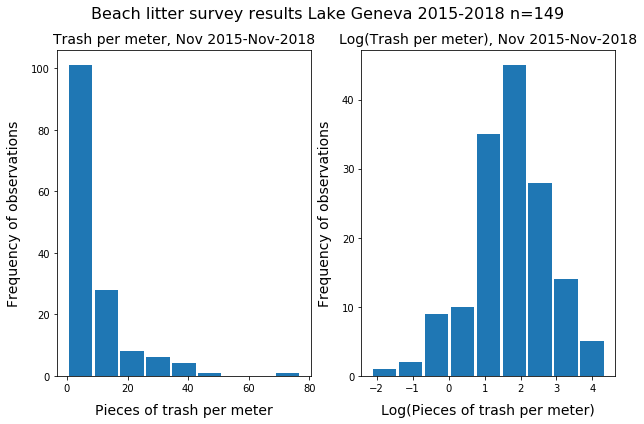

In [9]:
# wrtie the bar charts

fig, ax = plt.subplots(1,2, figsize=(10,6), sharey=False)
ax[0].hist(lakeDailyPcsM.pcs_m, bins=9, rwidth=0.9)
ax[0].set_xlabel("Pieces of trash per meter", size=14, labelpad=10)
ax[0].set_ylabel("Frequency of observations", size=14, labelpad=10)
ax[0].set_title("Trash per meter, Nov 2015-Nov-2018",size=14 )
ax[1].hist(lakeDailyPcsM.ln_pcs, bins=9, rwidth=0.9)
ax[1].set_xlabel("Log(Pieces of trash per meter)", size=14, labelpad=10)
ax[1].set_ylabel("Frequency of observations", size=14, labelpad=10)
ax[1].set_title("Log(Trash per meter), Nov 2015-Nov-2018",size=14 )
plt.suptitle("Beach litter survey results Lake Geneva 2015-2018 n=" + str(len(lakeDailyPcsM.pcs_m)), fontsize=16, family='sans', horizontalalignment='center', y=.98 )
plt.show()
plt.close()

#### Kolmogorov-Smirnov test for goodness of fit log(pcs/m) to lognormal distribution:

In [10]:
lnList = np.array(lakeDailyPcsM.ln_pcs)
muLnAll = np.mean(lnList)
sigmaAll = np.std(lnList)
kStestOne = scipy.stats.kstest(lnList, 'norm', args=(muLnAll, sigmaAll))
print("Kolmogorov-Smirnov test satistic is " + str(np.round(kStestOne[0], 3)) + ", the pvalue is " + str(np.round(kStestOne[1], 3)))


Kolmogorov-Smirnov test satistic is 0.064, the pvalue is 0.557


### Year over year distributions

1. Boxplots of year over year non transformed data
2. PDF of year over year log transformed data 


In [11]:
# create box plots of year over year results:
# need to make a column identifier for the year based on date:
lakeDailyPcsM["Year"]=0
lakeDailyPcsM.loc[lakeDailyPcsM.date < "2016-11-15", "Year"] = 1
lakeDailyPcsM.loc[(lakeDailyPcsM.date >= "2016-11-15")&(lakeDailyPcsM.date < "2017-11-15"), "Year"] = 2
lakeDailyPcsM.loc[(lakeDailyPcsM.date >= "2017-11-15")&(lakeDailyPcsM.date < "2018-11-15"), "Year"] = 3

#! This was added after the fact needs to be factored into output downstream

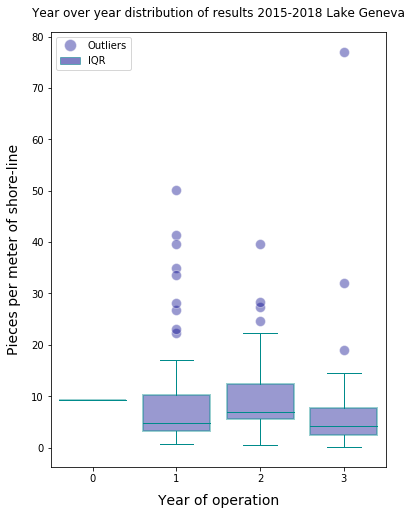

In [12]:
yearOverYearBox(lakeDailyPcsM)

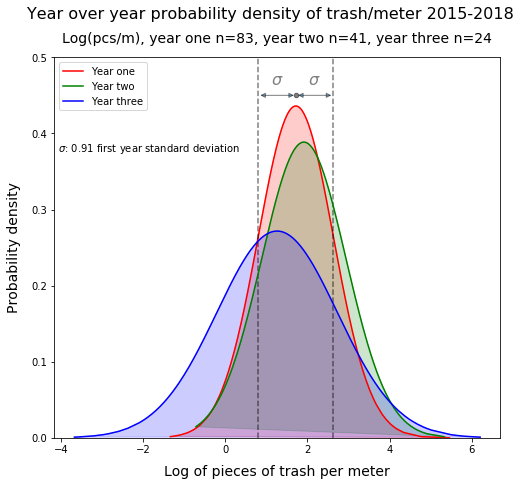

In [13]:
# Get the data by date groups:
xS = makeYearResults(["2016-11-15", "2017-11-15", "2018-11-15"],lakeDailyPcsM, "ln_pcs")

# Turn that into x,y coordinates
Data = makeXandY(xS)

# Give it a six in inches
figSize = (8,7)

# Pick your colors
colors = ["r", "g", "b"]

# Admin information
labels = ["Year one", "Year two", "Year three"]
title = "Year over year probability density of trash/meter 2015-2018"
subTitle = "Log(pcs/m), year one n=83, year two n=41, year three n=24"
saveFig = "graphs/distributions/logYearOverYear.svg"

# Draw the chart:
aveStd = makeYearOverYear(Data, figSize, colors, labels, title, subTitle, saveFig)


### Testing the log-normal assumption 
 
#### Combined results of SLR and MCBP

1. SLR and MCBP (139 of 148 samples)
2. Empirical versus log
3. QQ plots
4. Kolmogorov-Smirnov test for goodness of fit - lognormal.

### Definition of Theta and x:

__Theta = theoretical distribution__

Log(Theta) was drawn from a normal distribution where mu = average of the "ln_pcs" column and sigma = standard deviation of the "ln_pcs" column.
        
__x = empirical results__

X = the the column "pcs_m" from the data and log(x) = the column "ln_pcs" from the data.

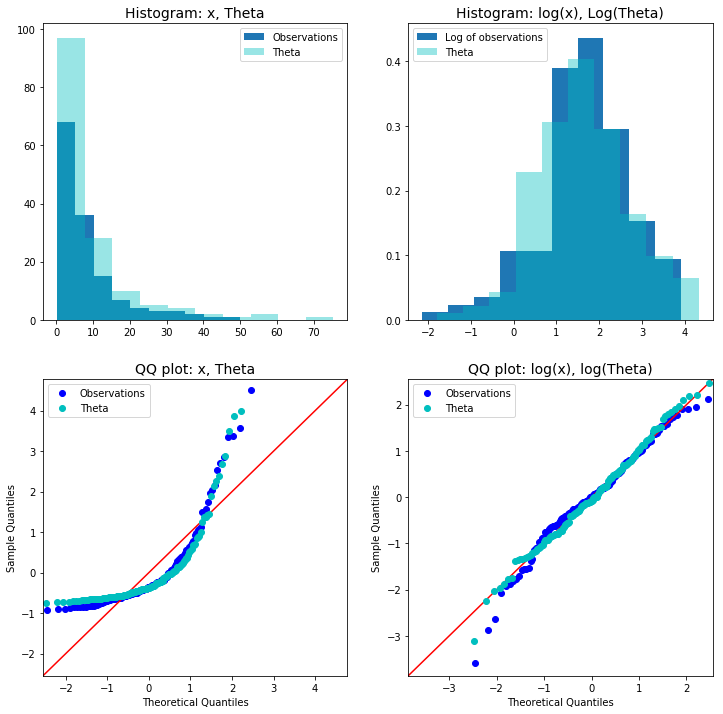

In [14]:
x = list(lakeDailyPcsM[lakeDailyPcsM.Project.isin(["SLR", "MCBP"])]["pcs_m"])
x =sorted(x)
mu = np.mean(x);sigma = np.std(x);med = np.median(x);maxX = np.max(x);minX=np.amin(x)

xLn = list(lakeDailyPcsM[lakeDailyPcsM.Project.isin(["SLR", "MCBP"])]["ln_pcs"])
muL = np.mean(xLn);sigmaL = np.std(xLn);medL = np.median(xLn);maxXL = np.max(xLn);minXL=np.amin(xLn)
xLn = sorted(xLn)

fig, ax = plt.subplots(2,2, figsize=(12, 12))

xTheta = np.random.normal(muL, sigmaL, size=150)
xTheta = sorted(xTheta)

xThetaE = [np.exp(x) for x in  xTheta]

ax[0,0].hist(x, alpha=1, label="Observations")
ax[0,0].hist(xThetaE, alpha=0.4,color='c', label="Theta")
ax[0,1].hist(xLn,density=True, alpha=1, label="Log of observations")
ax[0,1].hist(xTheta, density=True,color='c', alpha=0.4, label="Theta")
sm.qqplot(np.array(x), dist="norm", fit=True, ax=ax[1,0], line='45', label="Observations")
sm.qqplot(np.array(xThetaE), dist="norm",color='c', fit=True, ax=ax[1,0], label="Theta")
sm.qqplot(np.array(xLn), dist="norm", fit=True, ax=ax[1,1], line='45', label="Observations")
sm.qqplot(np.array(xTheta), dist="norm",color='c', fit=True, ax=ax[1,1], label="Theta")

# ax[1,0].hist(x, density=True,alpha=1)
# ax[1,0].hist(xGamma, density=True, alpha=0.4)
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

ax[0,0].set_title("Histogram: x, Theta", fontsize=14)
ax[0,1].set_title("Histogram: log(x), Log(Theta)", fontsize=14)
ax[1,0].set_title("QQ plot: x, Theta", fontsize=14)
ax[1,1].set_title("QQ plot: log(x), log(Theta)", fontsize=14)
plt.show()
plt.close()

#### Kolmogorov-Smirnov test for goodness of fit of the combined distribution.

1. Testing the data from the API:

In [15]:
kStestTwo = scipy.stats.kstest(np.array(xLn), 'norm', args=(muL, sigmaL))

print("Kolmogorov-Smirnov test satistic is " + str(np.round(kStestTwo[0], 3)) + ", the pvalue is " + str(np.round(kStestTwo[1], 3)))

Kolmogorov-Smirnov test satistic is 0.069, the pvalue is 0.504


#### Discussion

All surveys reported some trash. The quantities vary from 0.12pcs/m to 77.06pcs/m. __The non transformed data__ is summarised as follows :

1. mean       9.160844
2. std       10.752655
3. min        0.117647
4. 25%        3.183535
5. 50%        5.526347
6. 75%       11.240594
7. max       77.055556

The mean is almost double the median and the innerquantile range is less than the standard deviation.  Suggesting that there are some extreme values pulling the tail to the positive side. Specifically one survey by SWE at 77pcs/m 

__The transformed data__ is summarised as follows:

1. mean       1.695891
2. std        1.078434
3. min       -2.140066
4. 25%        1.157820
5. 50%        1.709305
6. 75%        2.419525
7. max        4.344527

The transformation shifts the mean to the left of the median. Bringing the distribution closer to normal but with a negative skew. This can be explained by the series of surveys in Gland (SLR) which consistently reported the lowest pcs/m values in year two and three.

__Assumption:__ These values follow a lognormal distribution.

Using the mean and standard deviation from the observed data a theoretical lognormal distribution was created. Theta, is a randomly selected distribution of size 150 from that theoretical distribution. The histogram and Quantile-Quantile (QQ) plots of Theta were compared to the corresponding combined empirical results (x) for MCBP and SLR.

The histogram and QQ plot of Theta show an increase in the number of observations of less than 40pcs/m and an extension of the positive tail to 60pcs/m. The same charts for log(Theta) and log(x) show the increase as a consolidation of the values of the negative tail. Log(Theta) has no values less than -1.5 and an increase of values -1.5 < log(Theta) <= 1 with an almost mirrored result for values 2.5 < log(Theta) <= 2.2.

When the cumulative distribution function (CDF) of log(x) is compared to a CDF of a normal distribution of the same parameters the largest vertical distance is 0.069 with a P value of 0.5 (Kolmogorov-Smirnov test). This result, combined with with the quantile comparisons and the visual inspection of the histograms, we refuse to reject the null hypothesis that log(x) is a lognormal distribtution.

__Year over year results__

The results were seperated by year (starting November 15 each year)\*. For each year the data is positiveley skewed. The minimum and maximum values for the three year period were recorded in the third year which also exhibits the lowest median value. Like the first year more than 50% of the samples were collected by one group and 15 of the 24 samples came from three locations.  In year two no group had 50% of the samples, the ratio #locations/#samples was the highest and so was the median value.\**  

The mean and standard deviation of the log of the results for each year was used to generate a distribution based on a random normal distribution using numpy.random.normal(loc, scale, n). When the averages from year two (1.91) and year three (1.25) are compared to year one they both fall within one standard deviation of the mean of year one(1.71).

*Nov 15, 2015 is the first recorded observation using the MLW survey method on the lake.

\**See spreadsheet _piecesPerMeterYear.xlsx_


In [16]:
# this gets hidden on output
# get the data:
yearOnePcs = {"YearOnePcsM":lakeDailyPcsM[lakeDailyPcsM.date < "2016-11-15"]}
yearOneStats = {"YearOneStats":lakeDailyPcsM[lakeDailyPcsM.date < "2016-11-15"].describe()}
yearTwoPcs = {"YearTwoPcsM":lakeDailyPcsM[(lakeDailyPcsM.date >= "2016-11-15")&(lakeDailyPcsM.date < "2017-11-15")]}
yearTwoStats = {"YearTwoStats":lakeDailyPcsM[(lakeDailyPcsM.date >= "2016-11-15")&(lakeDailyPcsM.date < "2017-11-15")].describe()}
yearThreePcs = {"YearThreePcsM":lakeDailyPcsM[(lakeDailyPcsM.date >= "2017-11-15")&(lakeDailyPcsM.date < "2018-11-15")]}
yearThreeStats = {"YearThreeStats":lakeDailyPcsM[(lakeDailyPcsM.date >= "2017-11-15")&(lakeDailyPcsM.date < "2018-11-15")].describe()}

# put all that in a list
byYear = [yearOnePcs, yearOneStats, yearTwoPcs, yearTwoStats, yearThreePcs, yearThreeStats]

# put this in an excel workbook
putListExcel(byYear, "data/PiecesMeterYear.xlsx")

## Defining a population

#### MCBP and SLR account for 139 of the 148 surveys

The surveys from MCBP cover all regions of the lake, including the only survey in France. There was no change in personnel and MCBP has surveys in all three years.

SLR Surveys account for three locations in year two and three. The personnel were trained by the WWF and committed to doing 12 surveys a year.

The results from year one and three are similar:

1. Low median value
2. Ratio of #surveys/#locations is lower than year two
3. MCBP did most of the surveys in year one, SLR year three

Given these reasons we compared the distribtution of results between these two projects. Using the log-transformed  method as above. The results are below:

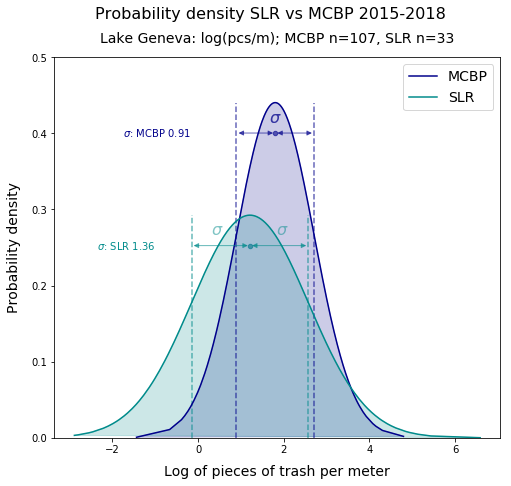

In [17]:
mcbp = list(lakeDailyPcsM[lakeDailyPcsM.Project == "MCBP"]["ln_pcs"])
slr = list(lakeDailyPcsM[lakeDailyPcsM.Project == "SLR"]["ln_pcs"])
thisList = [("MCBP",mcbp), ("SLR",slr)]
projectData =  makeXandYProject(thisList)
makeProjectDist(projectData, (8,7), ["darkblue", "darkcyan"], "graphs/distributions/logProject.svg")

#### Discussion

The distribution of MCBP falls entireley within the distribution of SLR. Furthermore almost 68% of the data from MCBP falls within one standard deviation of the mean of the SLR distribution.

There are other similarities between the two groups:

1. Repeated surveys over time, more experience
2. Both groups have sustained activity in the environmental field
3. Data was collected and reported independently 

The combined results of the two projects were combined to make up a representative population of "pieces of trash per meter of shore line".

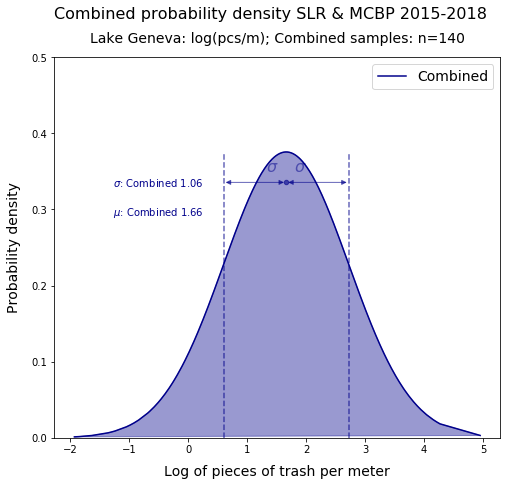

In [18]:
combined = list(lakeDailyPcsM[lakeDailyPcsM.Project.isin(["SLR", "MCBP"])]["ln_pcs"])
combinedList = [("Combined", combined)]
combinedProjectData =  makeXandYProject(combinedList)
def makeProjectDistX(Data, figSize, colors, saveFig):
    fig, ax = plt.subplots(figsize=figSize)
    ax.set_ymargin(0)
    samples = {}
    textLabel = []
    for i, data in enumerate(Data):
        if i == 0:
            samples.update({i:(data[5])})
            ax.plot(data[1], data[2], color=colors[i], label=data[0], zorder=1)
            ax.fill(data[1], data[2], color=colors[i], alpha=0.4, zorder=1)
            ymax = data[2].max()
            vOne = np.round(data[3] + data[4], 3)
            vTwo = np.round(data[3] - data[4], 3)
            stdOne = np.round(data[4], 2)
            meanOne = np.round(data[3], 2)
            textLabel.append([data[0], stdOne])
            plt.vlines(vOne, ymin=0, ymax=ymax, linestyles="--", color=colors[i], alpha=0.6)
            plt.vlines(vTwo, ymin=0, ymax=ymax, linestyles="--", color=colors[i], alpha=0.6)
            adjust = i/4
            ax.annotate("", xy=(vTwo, ymax-.04), xycoords='data',
                        xytext=(meanOne, ymax-.04), textcoords='data',
                        arrowprops=dict(arrowstyle="<|-|>", alpha=0.6, color=colors[i],
                                        connectionstyle="arc3"))
            ax.annotate("", xy=(vOne, ymax-.04), xycoords='data',
                        xytext=(meanOne, ymax-.04), textcoords='data',
                        arrowprops=dict(arrowstyle="<|-|>", alpha=0.6,color=colors[i],
                                        connectionstyle="arc3"))
            left, right = plt.xlim()
            ax.text(left+1, ymax-.04, r'$\sigma$: ' + data[0] + ' ' + str(stdOne),
                    {'color': colors[i], 'fontsize': 10, 'ha': 'left', 'va': 'center'})
            ax.text(left+1, ymax-.08, r'$\mu$: ' + data[0] + ' ' + str( meanOne),
                    {'color': colors[i], 'fontsize': 10, 'ha': 'left', 'va': 'center'})
            ax.scatter(meanOne, ymax-.04, s=20, color=colors[i], alpha=0.6)
            ax.text(vTwo+(data[3]/2), ymax-.02, r'$\sigma$',
                    {'color': colors[i], 'fontsize': 16, 'ha': 'center', 'va': 'center'},alpha=0.5)
            ax.text(vOne-(data[3]/2), ymax-.02, r'$\sigma$',
                    {'color': colors[i], 'fontsize': 16, 'ha': 'center', 'va': 'center'},alpha=0.5)
        else:
            samples.update({i:(data[5])})
            ax.plot(data[1], data[2], color=colors[i], label=data[0], alpha=1, zorder=0)
            ax.fill(data[1], data[2], color=colors[i], alpha=0.4, zorder=0)           



    ax.legend(fontsize=14)
    ax.set_ylim(top=0.5)
    ax.set_ylabel("Probability density", labelpad= 10, color='black', fontsize=14)
    ax.set_xlabel('Log of pieces of trash per meter', labelpad= 10, color='black', fontsize=14)


    plt.suptitle("Combined probability density SLR & MCBP 2015-2018" ,
                     fontsize=16, family='sans', horizontalalignment='center', y=0.98 )
    plt.title("Lake Geneva: log(pcs/m); Combined samples: n=" + str(samples[0]),
              fontsize=14, family='sans', loc="center", pad=15)

    plt.savefig(saveFig)
    plt.show()
    plt.close()


makeProjectDistX(combinedProjectData, (8,7), ["darkblue", "darkcyan", "peachpuff"], "graphs/distributions/combinedProject.svg")

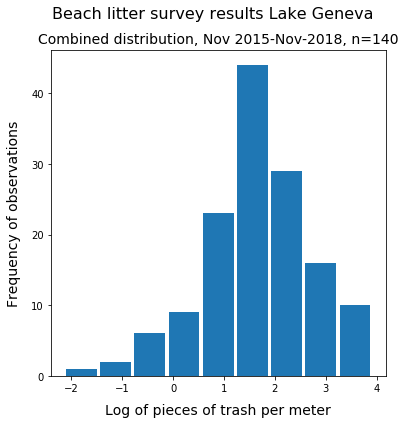

In [19]:
makeHist(lakeDailyPcsM[lakeDailyPcsM.Project.isin(["SLR", "MCBP"])]["ln_pcs"], 9, (6, 6),"Combined distribution, Nov 2015-Nov-2018, n=", "Beach litter survey results Lake Geneva", "Log of pieces of trash per meter", "Frequency of observations", "graphs/histograms/pcsMhist.svg")

### Comparing samples from other groups against the combined distribution

#### The results from SWE, PC and GIS were excluded from the combined distribution

In the same way that there are similarities between SLR and MCBP, there are charatersitics that make these groups unique. Making them representative of a random sample based on the same protocol.

1. Few samples (less experience)
2. SWE the particpants changed each year, they are university students
3. GIS is elementary school children
4. Neither MCBP or SLR have samples at these locations

The results from the random samples were plotted against the distribution of the combined results:

In [20]:
# this gets hidden
# Group the SLR and MCBP results:
xLsX = lakeDailyPcsM[lakeDailyPcsM.Project.isin(["SLR", "MCBP"])]
# Get the mean and standard deviation from that group:
xLsXStat = xLsX["pcs_m"].describe()
mu = xLsXStat["mean"]
sigma = xLsXStat["std"]
# Put the results in a list and sort
# This is empirical
xS = list(xLsX.pcs_m)
xS = sorted(xS)
# This is the log
xLnS = list(xLsX.ln_pcs)
xLnS = sorted(xLnS)

# Get the emprical results for the random samples
swePcs = list(lakeDailyPcsM[lakeDailyPcsM.Project == "SWE"]["pcs_m"])
gisPcs = list(lakeDailyPcsM[lakeDailyPcsM.Project == "GIS"]["pcs_m"])
pcPcs = list(lakeDailyPcsM[lakeDailyPcsM.Project == "PC"]["pcs_m"])

# Get the log of the results for the random samples
swePcsLn = list(lakeDailyPcsM[lakeDailyPcsM.Project == "SWE"]["ln_pcs"])
gisPcsLn = list(lakeDailyPcsM[lakeDailyPcsM.Project == "GIS"]["ln_pcs"])
pcPcsLn = list(lakeDailyPcsM[lakeDailyPcsM.Project == "PC"]["ln_pcs"])

In [21]:
# this gets hidden
# the data for the boxplots
dataOne = xS
dataTwo = xLnS
colorsBox = ["darkblue","darkcyan" ]

# data for the random samples
samplesOne = [swePcs, pcPcs, gisPcs]
samplesTwo = [swePcsLn, pcPcsLn, gisPcsLn]
colorsSamps = ["fuchsia", "indigo", "peachpuff"]
namesSamples = ["SWE", "PC", "GIS"]

# titles and file location
figTitle = "Distribution of combined results - MCBP & SLR, Lake Geneva 2015-2018"
axOneTitle = 'Plot of pcs/m'
axTwoTitle = 'Plot of Log(pcs/m)'
fileName = "graphs/distributions/combinedBox.svg"

#### The boxplots:

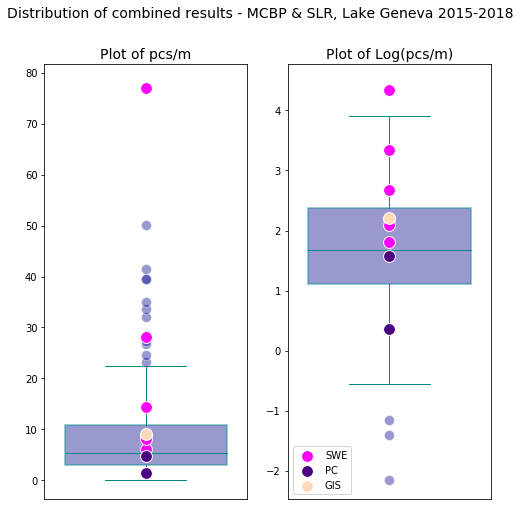

In [22]:
# call the function
sideBysideBoxPlots(dataOne, dataTwo, colorsSamps,colorsBox, namesSamples, 
                   samplesOne, samplesTwo, figTitle, axOneTitle, axTwoTitle, fileName)

#### The cumulative distribution:

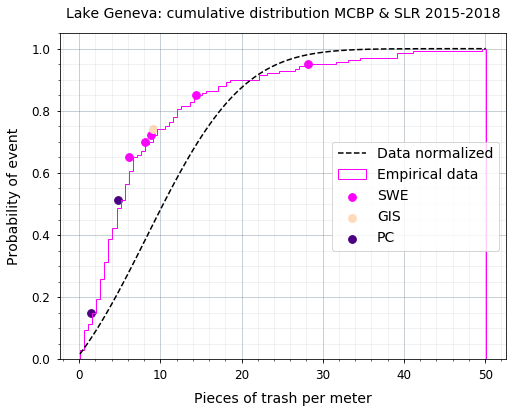

In [23]:
tryThis, results = makeCumlativeDist(xS, mu, sigma, 100, "Empirical data", "Data normalized",
                                     swePcs, gisPcs, pcPcs)

#### Discussion

Whether the empirical data or the log transform* is used five of the nine samples fall within the interquartile range** of the theoretical population . As was seen earlier when all the results are conisedered the shift to the right caused by the log transform captures eight of the nine samples.

The whiskers account for > 99% of all possible values in the distribution. With the exception of the two extreme values the combined distribution accounts for all the random samples.

*This is the distribution of the log of the actual values __not a derived sample based on the average and standard deviation__

**There are two samples with almost identical values that make this difficult to see.

## Conclusion

### Sampling method:

#### Protocol:

The similarity of survey results and the corresponding probability distribtutions confirm the validity of the protocol. Specifically for quantifying observations of litter surveys from different groups and estimating the minimum amount of trash per meter of shoreline. 

The results from the third year suggest that a minimum number of samples and locations per year (or period) are required to obtain a valid distribution. 

#### Number of samples and locations:

Given the year over year results the estimated minimum samples is between 40 and 80 and the minimum number of locations is between 15 and 20. 

Optimally the ratio of locations to samples should be .21 and .45 with no particular group collecting more than 50% of the samples.

Following these recomendations we could eliminate geographic bias and mitigate the differences associated with data collected in the field by disparate groups.  

### Estimating trends:

To identify trends on a per period basis an adequate number of samples in the correct ratio of locations/samples is required. For Lake Geneva the year over year results stay within one standard deviation of the mean. 

In terms of trash per meter we can say with confidence that an observer on Lake Geneva was just as likely to find 5 pieces of trash (50% chance) per meter in 2015 as in 2018. Values up to 12pcs/m are probable 25% of the time 30 pcs/m 5% of the time. 

This indicates that __there is no signifigant change in the amount of observed beach litter between 2015-2018 on Lake Geneva__.  This assumption can not be propagated down to individual locations(except those locations that have an adequate number of samples).

The results from these surveys do not speak to the maximum values. Given the current distribution, values in excess of 70 pieces of trash per meter are to be expected. There is no safe area from this phenomenom. Values in excess of 40pcs/m have been recorded in St. Gingolph, Vevey and St. Sulpice.

There is no reason to believe that these values will change in 2019.

### Estimating efficency:

An analysis of resources expended for the periods 2013-2018 should not be excluded. Correlating a report of this nature with the results of this study would at least:

1. Indentify projects that have greater value
2. Identify potential cost savings through consolidation
3. Verify that all actors are working in the same direction

Efficient use of financial resources is key to solving this problem. Responsible parties of civil society and government should be scrutinzing the resources allocated to the problem. 

### Going forward:

#### Open data:

The results from this study should be compared to economic indicators and hydrologic data. Unfortunateley those resources are not forthcoming. The Swiss Federal Office of the Environment charges a fee for consolidated data from river dishcarge rates. The CIPEL offers data but it is two dimensional and already aggregated (and the aggregation methods are not disclosed). INRA will not release any data on Lac Léman without going through a lengthy interview process and offcial relations with a university.

All of these are signifigant roadblocks to determining sources of pollution and quanitfying the appropriate allocation of resources.

#### Identifying the most common items:

For a quick assesment of the most common items the webpage has all the information. However an in-depth analysis has yet to be completed for the three year period.

#### Surveillance

The results from 2015-2018 clearly establish a baseline for minimum quantities of observable trash. Hammerdirt will continue to conduct beach litter surveillance in our region (Vevey-Montreux) with random operations at other locations. 

Particular attention will be given to :

1. Plastic beads from manufacturing
2. Ratio of #locations/#samples

To the best of our ability we will continue to maintain the API and online data services. For this reason we have eliminated all expenses not directly related to beach-litter surveillance and analysis.